# Импорт бибилиотек и функций

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig = plt.subplots(figsize=(5, 4))

  # график значения функции потерь на каждой эпохе
  plt.plot(epochs_x, loss_values, 'b', label='Ошибка обучения')
  plt.plot(epochs_x, val_loss_values, 'r', label='Ошибка валидации')
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.grid()
  plt.legend()

  return

def print_error(y_test, y_pred):
  # ошибка предсказания
  mae = (mean_absolute_error(y_test, y_pred))
  mse = (mean_squared_error(y_test, y_pred))
  print('MAE: %.10f' % (mae))
  print('RMSE: %.10f' % math.sqrt(mse))
  print('MSE: %.10f' % (mse))

  performance_scores = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': math.sqrt(mse),
  }

  return performance_scores


def plot_result(y_test, y_pred):
  rows = len(y_test)
  plt.figure(figsize=(15, 6),dpi=100)
  plt.plot(range(rows), y_test)
  plt.plot(range(rows), y_pred, linewidth=0.9)
  plt.legend(['Реальная температура', 'Предсказание'])
  plt.xlabel('Номер наблюдения')
  plt.ylabel('Отмасштабированная температура')
  plt.title('Реальная и предсказанная температура')
  plt.xlim(0, rows - 1)
  plt.grid()

# Чтение данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 31 02:14 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d arunavakrchakraborty/australia-weather-data

  0% 0.00/3.86M [00:00<?, ?B/s]
100% 3.86M/3.86M [00:00<00:00, 154MB/s]


In [154]:
!kaggle datasets download -d emmanuelfwerr/london-weather-data

  0% 0.00/226k [00:00<?, ?B/s]
100% 226k/226k [00:00<00:00, 97.2MB/s]


In [155]:
# разархивирование данных
!unzip "/content/london-weather-data.zip" -d "/content/london_weather"

Archive:  /content/london-weather-data.zip
  inflating: /content/london_weather/london_weather.csv  


# Исследование данных

In [5]:
df = pd.read_csv('/content/london_weather/london_weather.csv') # читаем данные в перменную df

In [6]:
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [7]:
print(f"Количество переменных: {df.shape[1]}, количество данных: {df.shape[0]}")

Количество переменных: 10, количество данных: 15341


<Axes: >

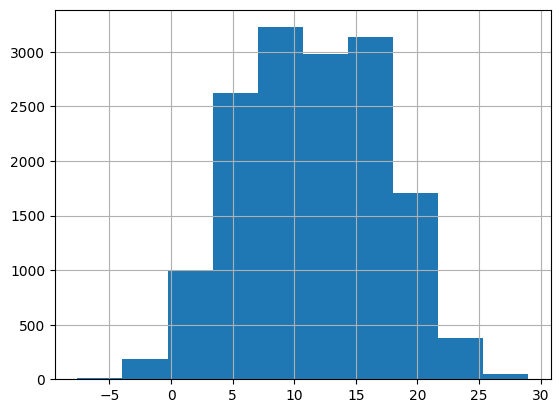

In [8]:
df["mean_temp"].hist() #посмотрим на распределение целевой переменной

In [9]:
# проверим на пропуски и если они есть удалим
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [10]:
df = df.dropna(subset=['mean_temp']) # удаляем те строки, в которых естьь пропущенные значения в столбце mean_temp

In [11]:
df.isna().sum() # проверим все ли пропуски были удалены

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp              0
min_temp               0
precipitation          2
pressure               4
snow_depth          1424
dtype: int64

In [12]:
# выполним масштабирование данных (от 0 до 1)
data = df['mean_temp'].values
scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform(data).flatten()

In [13]:
# выполним сглаживание данных для уменьшение отдельных значений, содержащих статистические аномалии
def get_XY(data, window):
  Y_index = np.arange(window, len(data), window)
  Y = data[Y_index]
  rows_x = len(Y)
  X = data[range(window*rows_x)]
  X = np.reshape(X, (rows_x, window, 1))
  return X, Y

In [14]:
# выполним обработку скользящим окном размера 10
window = 10
X, y = get_XY(data, window)

# Деление выборки

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
print(f"Разммер обучающей выборки {X_train.shape[0]}")
print(f"Разммер тестовой выборки {X_test.shape[0]}")

Разммер обучающей выборки 1224
Разммер тестовой выборки 306


# Модель 1

In [17]:
# функция для создания полносвязной модели рекуррентной нейронной сети с одним скрытым слоем
def create_RNN(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=False))
  model.add(Dense(units=dense_units, activation=activation[1])) # выходной слой - температура

  model.compile(loss='mean_squared_error', # функции потерь - средняя абсолютная ошибка (mae)
                optimizer='adam', # оптимизатор adam
                metrics=['mean_absolute_error', 'mean_squared_error']) # метрики - mse и mae

  model.summary()
  return model

In [18]:
model = create_RNN(hidden_units=32,
                   dense_units=1,
                   input_shape=(window, 1),
                   activation=['relu', 'linear'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение

In [19]:
history = model.fit(X_train, # входные признаки
                    y_train, # целевая переменная
                    epochs=30, # количество эпох обучения - 30
                    batch_size=32, # рамзер батча - 32
                    validation_split=0.2 # 20% из обучающей выборки будет использовано для валидации
                    )

Epoch 1/30
31/31 [==============================] - 4s 48ms/step - loss: 0.0208 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0208 - val_loss: 0.0062 - val_mean_absolute_error: 0.0632 - val_mean_squared_error: 0.0062
Epoch 2/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0043 - mean_absolute_error: 0.0519 - mean_squared_error: 0.0043 - val_loss: 0.0045 - val_mean_absolute_error: 0.0540 - val_mean_squared_error: 0.0045
Epoch 3/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0040 - mean_absolute_error: 0.0495 - mean_squared_error: 0.0040 - val_loss: 0.0042 - val_mean_absolute_error: 0.0516 - val_mean_squared_error: 0.0042
Epoch 4/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0036 - mean_absolute_error: 0.0476 - mean_squared_error: 0.0036 - val_loss: 0.0041 - val_mean_absolute_error: 0.0516 - val_mean_squared_error: 0.0041
Epoch 5/30
31/31 [==============================] - 1s 31ms/step - loss: 0.0036 - mean_absolute_erro

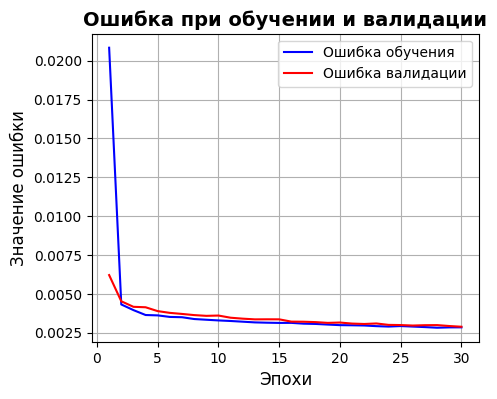

In [20]:
plot_training_curves(history)

In [21]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [22]:
model1_perf = print_error(y_test, y_pred)

MAE: 0.0425647088
RMSE: 0.0540081087
MSE: 0.0029168758


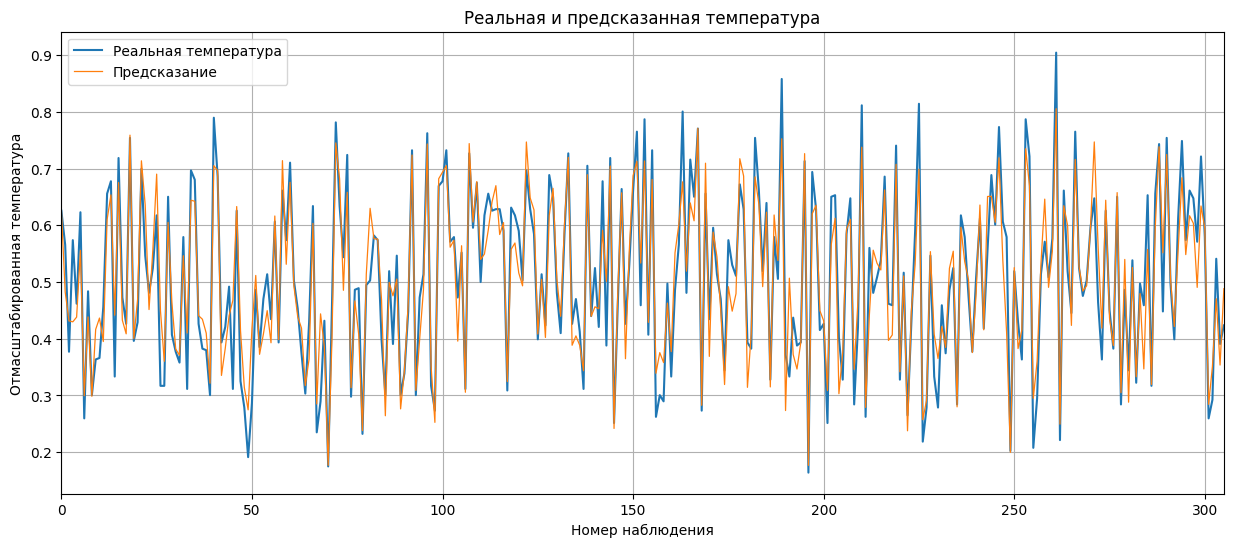

In [23]:
plot_result(y_test, y_pred)

# Модель 2

In [24]:
model = create_RNN(hidden_units=32,
                   dense_units=1,
                   input_shape=(window, 1),
                   activation=['relu', 'linear'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение

In [25]:
history = model.fit(X_train, # входные признаки
                    y_train, # целевая переменная
                    epochs=50, # количество эпох обучения - 50
                    batch_size=32, # рамзер батча - 32
                    validation_split=0.2 # 20% из обучающей выборки будет использовано для валидации
                    )

Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.1298 - mean_absolute_error: 0.2957 - mean_squared_error: 0.1298 - val_loss: 0.0136 - val_mean_absolute_error: 0.0978 - val_mean_squared_error: 0.0136
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0767 - mean_squared_error: 0.0093 - val_loss: 0.0061 - val_mean_absolute_error: 0.0643 - val_mean_squared_error: 0.0061
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_error: 0.0605 - mean_squared_error: 0.0059 - val_loss: 0.0059 - val_mean_absolute_error: 0.0636 - val_mean_squared_error: 0.0059
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_error: 0.0590 - mean_squared_error: 0.0056 - val_loss: 0.0056 - val_mean_absolute_error: 0.0615 - val_mean_squared_error: 0.0056
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_absolute_error: 0

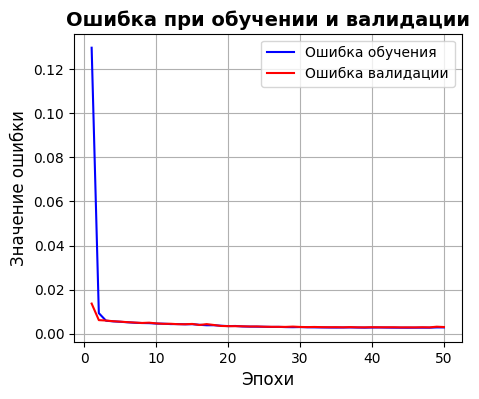

In [26]:
plot_training_curves(history)

In [27]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [28]:
model2_perf = print_error(y_test, y_pred)

MAE: 0.0438074100
RMSE: 0.0558783318
MSE: 0.0031223880


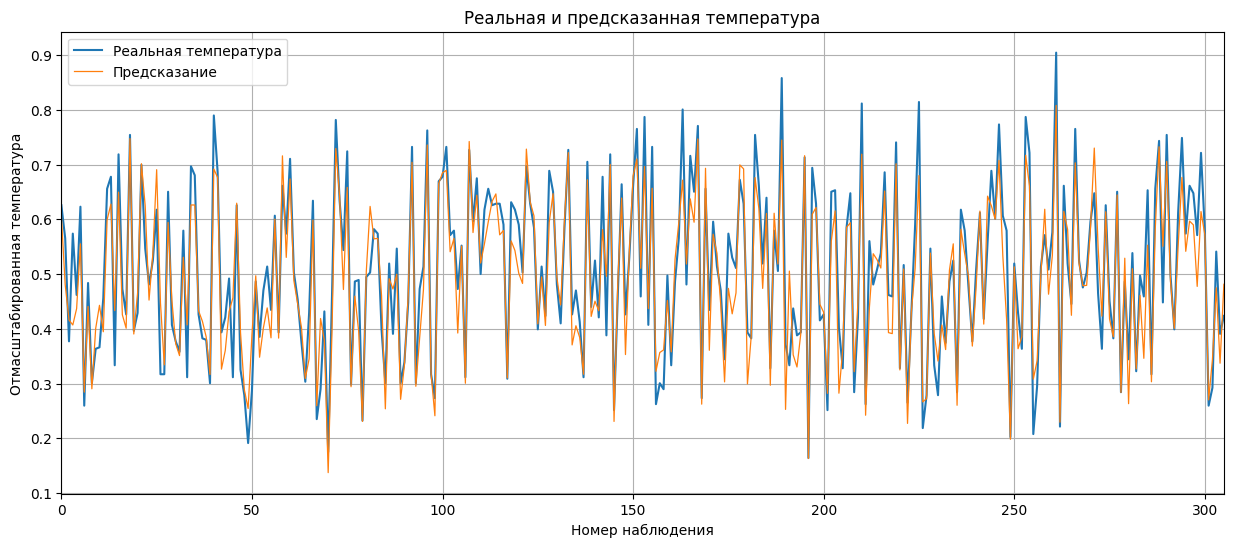

In [29]:
plot_result(y_test, y_pred)

# Деление выборки

In [30]:
# выполним обработку скользящим окном размера 20
window = 20
X, y = get_XY(data, window)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [32]:
print(f"Разммер обучающей выборки {X_train.shape[0]}")
print(f"Разммер тестовой выборки {X_test.shape[0]}")

Разммер обучающей выборки 612
Разммер тестовой выборки 153


# Модель 1

In [33]:
# функция для создания полносвязной модели рекуррентной нейронной сети с одним скрытым слоем
def create_RNN(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=False))
  model.add(Dense(units=dense_units, activation=activation[1])) # выходной слой - температура

  model.compile(loss='mean_squared_error', # функции потерь - средняя абсолютная ошибка (mae)
                optimizer='adam', # оптимизатор adam
                metrics=['mean_absolute_error', 'mean_squared_error']) # метрики - mse и mae

  model.summary()
  return model

In [34]:
model = create_RNN(hidden_units=32,
                   dense_units=1,
                   input_shape=(window, 1),
                   activation=['relu', 'linear'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение

In [35]:
history = model.fit(X_train, # входные признаки
                    y_train, # целевая переменная
                    epochs=50, # количество эпох обучения - 30
                    batch_size=32, # рамзер батча - 32
                    verbose=1,
                    validation_split=0.2 # 20% из обучающей выборки будет использовано для валидации
                    )

Epoch 1/50
16/16 [==============================] - 4s 103ms/step - loss: 0.0074 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0074 - val_loss: 0.0037 - val_mean_absolute_error: 0.0474 - val_mean_squared_error: 0.0037
Epoch 2/50
16/16 [==============================] - 0s 31ms/step - loss: 0.0034 - mean_absolute_error: 0.0458 - mean_squared_error: 0.0034 - val_loss: 0.0039 - val_mean_absolute_error: 0.0513 - val_mean_squared_error: 0.0039
Epoch 3/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0032 - mean_absolute_error: 0.0444 - mean_squared_error: 0.0032 - val_loss: 0.0034 - val_mean_absolute_error: 0.0469 - val_mean_squared_error: 0.0034
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0032 - mean_absolute_error: 0.0444 - mean_squared_error: 0.0032 - val_loss: 0.0033 - val_mean_absolute_error: 0.0465 - val_mean_squared_error: 0.0033
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_absolute_err

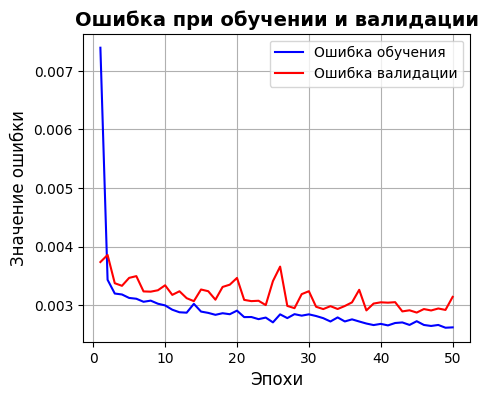

In [36]:
plot_training_curves(history)

In [37]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [38]:
model3_perf = print_error(y_test, y_pred)

MAE: 0.0433834639
RMSE: 0.0575789377
MSE: 0.0033153341


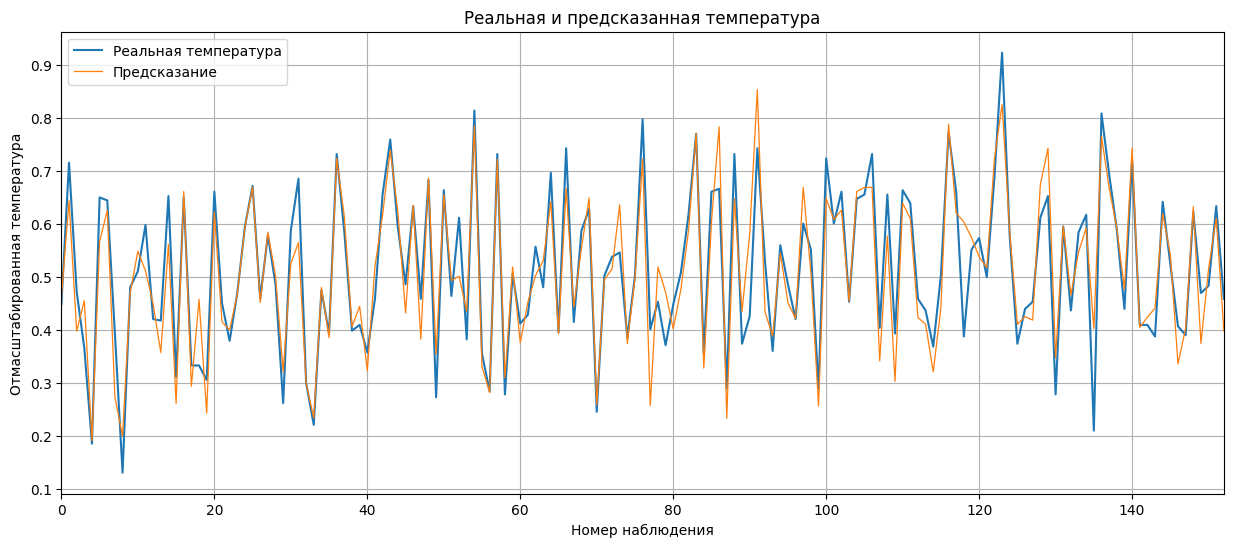

In [39]:
plot_result(y_test, y_pred)

In [40]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'model_1': model1_perf,
    'model_2': model2_perf,
    'model_3': model3_perf
}).T

performance_df

,MAE,MSE,RMSE
model_1,0.042565,0.002917,0.054008
model_2,0.043807,0.003122,0.055878
model_3,0.043383,0.003315,0.057579
